# VQAs on a Graph

In [58]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
from copy import copy
from typing import List
#from qc_grader.graph_util import display_maxcut_widget, QAOA_widget, graphs
mpl.rcParams['figure.dpi'] = 300

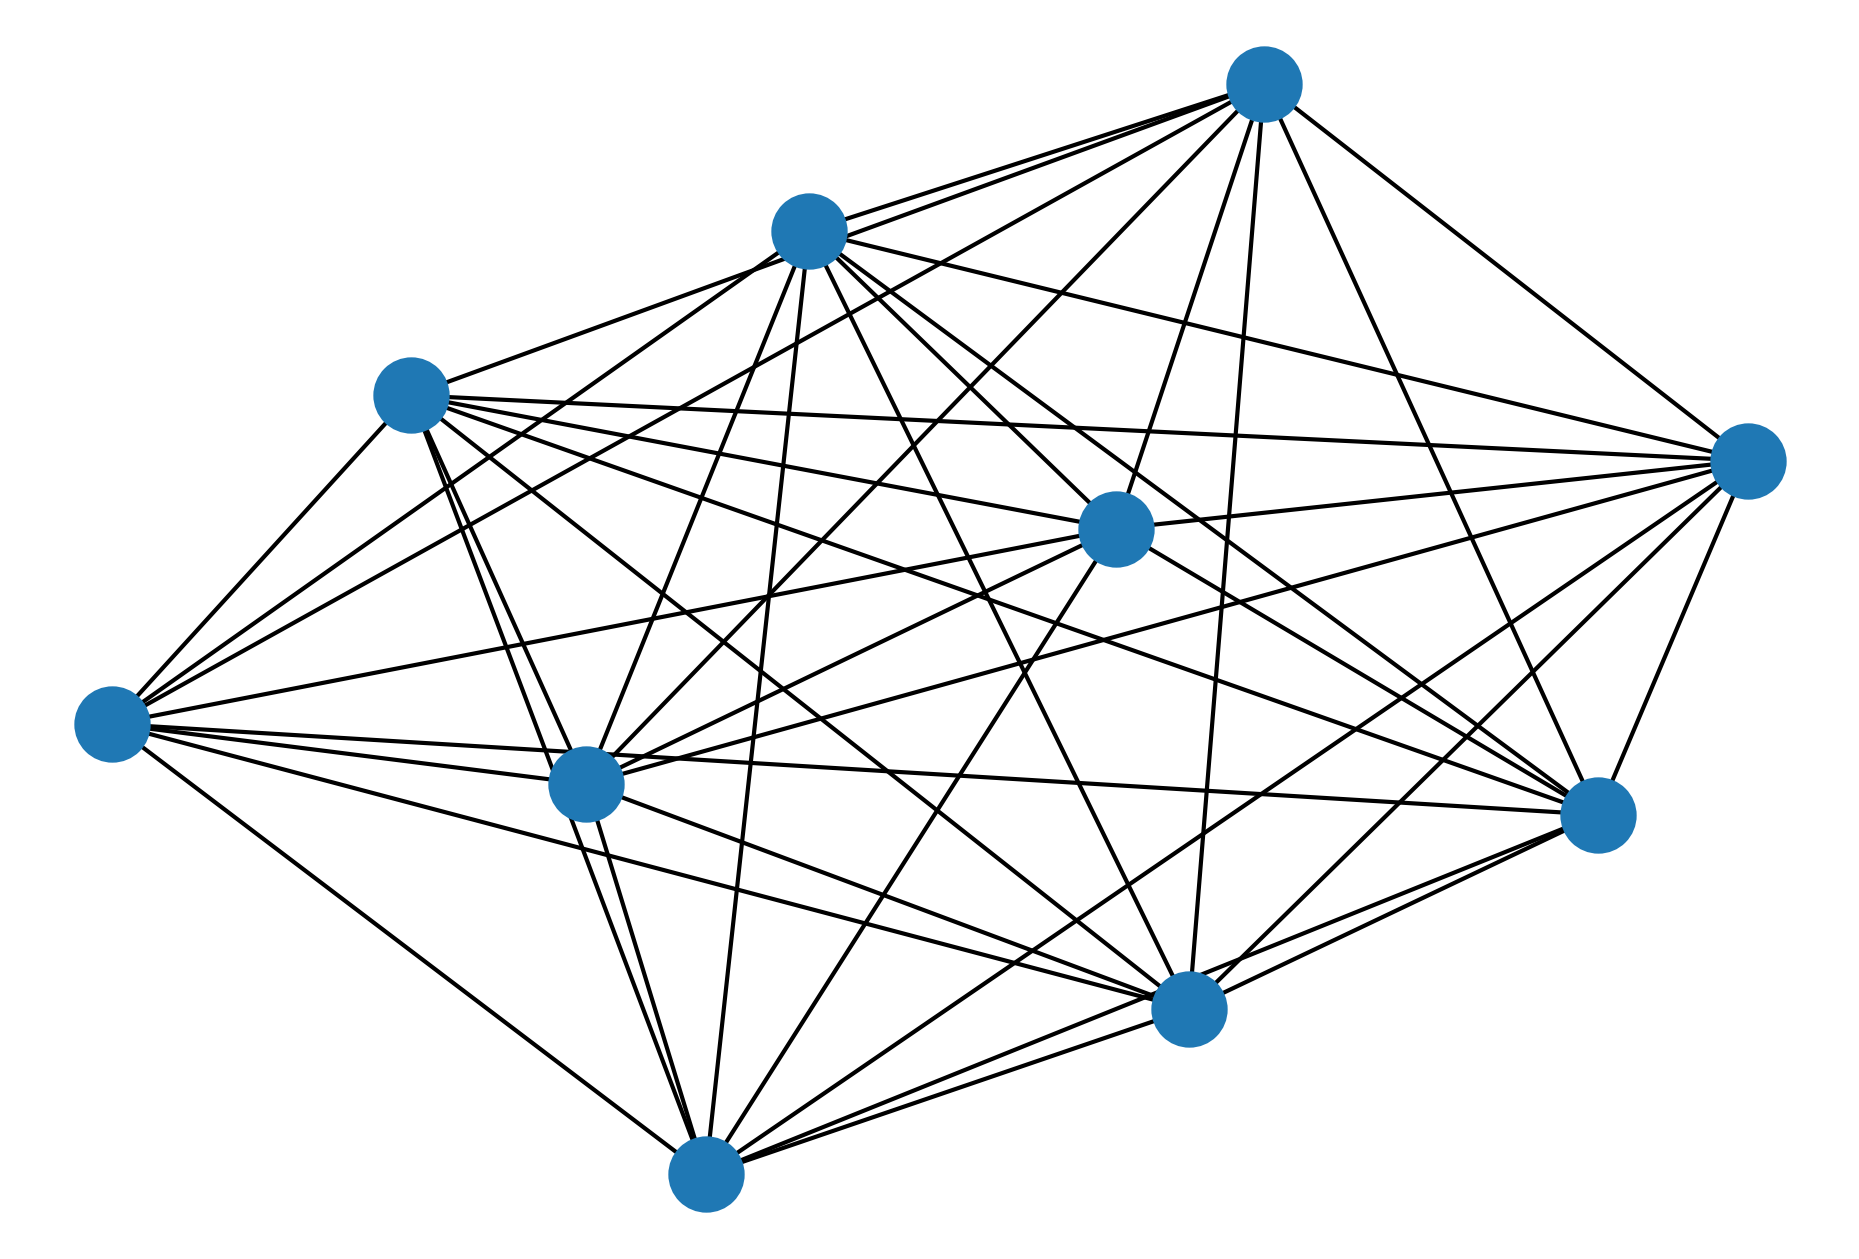

In [59]:
#https://networkx.org/documentation/stable/reference/generators.html
G = nx.turan_graph(10, 5)
#G = nx.karate_club_graph()
nx.draw(G)
plt.show()

In [60]:
G.edges

EdgeView([(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 8), (6, 9), (7, 8), (7, 9)])

In [61]:
#Here I add some weights to the edges
for i in G.edges:
    G[i[0]][i[1]]['weight'] = np.random.randint(0, 30)
#G[0][4]['weight'] = 13
G.edges(data = True)
#G.get_edge_data(0, 1)

EdgeDataView([(0, 2, {'weight': 20}), (0, 3, {'weight': 26}), (0, 4, {'weight': 29}), (0, 5, {'weight': 6}), (0, 6, {'weight': 9}), (0, 7, {'weight': 22}), (0, 8, {'weight': 21}), (0, 9, {'weight': 2}), (1, 2, {'weight': 6}), (1, 3, {'weight': 6}), (1, 4, {'weight': 8}), (1, 5, {'weight': 18}), (1, 6, {'weight': 19}), (1, 7, {'weight': 1}), (1, 8, {'weight': 9}), (1, 9, {'weight': 4}), (2, 4, {'weight': 18}), (2, 5, {'weight': 21}), (2, 6, {'weight': 0}), (2, 7, {'weight': 8}), (2, 8, {'weight': 1}), (2, 9, {'weight': 26}), (3, 4, {'weight': 25}), (3, 5, {'weight': 12}), (3, 6, {'weight': 25}), (3, 7, {'weight': 7}), (3, 8, {'weight': 20}), (3, 9, {'weight': 21}), (4, 6, {'weight': 22}), (4, 7, {'weight': 3}), (4, 8, {'weight': 14}), (4, 9, {'weight': 12}), (5, 6, {'weight': 15}), (5, 7, {'weight': 0}), (5, 8, {'weight': 13}), (5, 9, {'weight': 22}), (6, 8, {'weight': 24}), (6, 9, {'weight': 0}), (7, 8, {'weight': 27}), (7, 9, {'weight': 14})])

## Now we have the Graph and I can solve the MAXCUT CLASSICALLY

In [68]:
def maxcut_cost_fn(graph: nx.Graph, bitstring: List[int]) -> float:
    """
    Computes the maxcut cost function value for a given graph and cut represented by some bitstring
    Args:
        graph: The graph to compute cut values for
        bitstring: A list of integer values '0' or '1' specifying a cut of the graph
    Returns:
        The value of the cut
    """
    #Get the weight matrix of the graph
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    size = weight_matrix.shape[0]
    value = 0.
    #print(len(bitstring))
    #print(size)
    for i in range(size):
        for j in range(size):
            value +=  weight_matrix[i, j]*bitstring[i]*(1-bitstring[j])
    return value

def plot_maxcut_histogram(graph: nx.Graph) -> None:
    """
    Plots a bar diagram with the values for all possible cuts of a given graph.
    Args:
        graph: The graph to compute cut values for
    """
    num_vars = graph.number_of_nodes()
    #Create list of bitstrings and corresponding cut values
    bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
    values = [maxcut_cost_fn(graph = graph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
    #Sort both lists by largest cut value
    values, bitstrings = zip(*sorted(zip(values, bitstrings), reverse=True))
    #Plot bar diagram
    bar_plot = go.Bar(x = bitstrings, y = values, marker=dict(color=values, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
    fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1000, height = 600))
    fig.show()
    return bitstrings[0], values[0]


In [69]:
a, b = plot_maxcut_histogram(graph = G)
print(a, b)

1100001011 374.0


The best combination is cambia quando eseguo lmao

## Now the MAXCUT with QUBO 

In [70]:
from qiskit_optimization import QuadraticProgram
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    """Constructs a quadratic program from a given graph for a MaxCut problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]

    #INSERT YOUR CODE HERE
    quadratic_program = QuadraticProgram('MaxCut_problem')
    for i in range(size):
        quadratic_program.binary_var(name = 'x_{}'.format(i))
    quadratic = qubo_matrix
    linear = qubo_vector
    quadratic_program.maximize(quadratic = quadratic, linear = linear)
    return quadratic_program

In [71]:
quadratic_program = quadratic_program_from_graph(G)
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut_problem

Maximize
 obj: 135 x_0 + 71 x_1 + 100 x_2 + 142 x_3 + 131 x_4 + 107 x_5 + 114 x_6
      + 82 x_7 + 129 x_8 + 101 x_9 + [ - 80 x_0*x_2 - 104 x_0*x_3 - 116 x_0*x_4
      - 24 x_0*x_5 - 36 x_0*x_6 - 88 x_0*x_7 - 84 x_0*x_8 - 8 x_0*x_9
      - 24 x_1*x_2 - 24 x_1*x_3 - 32 x_1*x_4 - 72 x_1*x_5 - 76 x_1*x_6
      - 4 x_1*x_7 - 36 x_1*x_8 - 16 x_1*x_9 - 72 x_2*x_4 - 84 x_2*x_5
      - 32 x_2*x_7 - 4 x_2*x_8 - 104 x_2*x_9 - 100 x_3*x_4 - 48 x_3*x_5
      - 100 x_3*x_6 - 28 x_3*x_7 - 80 x_3*x_8 - 84 x_3*x_9 - 88 x_4*x_6
      - 12 x_4*x_7 - 56 x_4*x_8 - 48 x_4*x_9 - 60 x_5*x_6 - 52 x_5*x_8
      - 88 x_5*x_9 - 96 x_6*x_8 - 108 x_7*x_8 - 56 x_7*x_9 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1
 0 <= x_6 <= 1
 0 <= x_7 <= 1
 0 <= x_8 <= 1
 0 <= x_9 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9
End



In [72]:
from qiskit_optimization.converters import QuadraticProgramToQubo

In [73]:
# Estimate the number of qubits required
ising_operations, _ = (
    QuadraticProgramToQubo()
    .convert(
        quadratic_program,
    )
    .to_ising()
)
print(f"Number of qubits required is {ising_operations.num_qubits}")

Number of qubits required is 10


In [74]:
from qiskit import IBMQ, Aer
from qiskit.algorithms import QAOA, VQE, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.providers.aer.noise.noise_model import NoiseModel

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

In [75]:
def get_classical_solution_for(quadprog: QuadraticProgram):
    # Create solver
    solver = NumPyMinimumEigensolver()

    # Create optimizer for solver
    optimizer = MinimumEigenOptimizer(solver)

    # Return result from optimizer
    return optimizer.solve(quadprog)

In [76]:
classical_result = get_classical_solution_for(quadratic_program)

# Format and print result
print("Solution found using the classical method:\n")
#print(f"Maximum crop-yield is {classical_result.fval} tons")
print(f"variables used are: ")

_vars = [v.name for v in quadratic_program.variables]
for idx, num in enumerate(classical_result.x):
    print(f"\t{num} ha of {_vars[idx]}")

Solution found using the classical method:

variables used are: 
	0.0 ha of x_0
	0.0 ha of x_1
	1.0 ha of x_2
	1.0 ha of x_3
	1.0 ha of x_4
	1.0 ha of x_5
	0.0 ha of x_6
	1.0 ha of x_7
	0.0 ha of x_8
	0.0 ha of x_9


In [77]:
classical_result #coindiced with the theoretical one!

optimal function value: 374.0
optimal value: [0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
status: SUCCESS

# Now a QAOA on Quantum simulator (or hardware is same)

In [78]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

backend = Aer.get_backend('statevector_simulator')
qaoa = QAOA(optimizer = ADAM(), quantum_instance = backend, reps=1, initial_point = [0.1,0.1])
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
quadratic_program = quadratic_program_from_graph(G)
result = eigen_optimizer.solve(quadratic_program)
print(result)

optimal function value: 374.0
optimal value: [0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
status: SUCCESS


In [79]:
def plot_samples(samples):
    """
    Plots a bar diagram for the samples of a quantum algorithm
    Args:
        samples
    """
    #Sort samples by probability
    samples = sorted(samples, key = lambda x: x.probability)
    #Get list of probabilities, function values and bitstrings
    probabilities = [sample.probability for sample in samples]
    values = [sample.fval for sample in samples]
    bitstrings = [''.join([str(int(i)) for i in sample.x]) for sample in samples]
    #Plot bar diagram
    sample_plot = go.Bar(x = bitstrings, y = probabilities, marker=dict(color=values, colorscale = 'plasma',colorbar=dict(title='Function Value')))
    fig = go.Figure(
        data=sample_plot, 
        layout = dict(
            xaxis=dict(
                type = 'category'
            )
        )
    )
    fig.show()

plot_samples(result.samples)

## VQE solution

In [80]:
def get_VQE_solution_for(
    quadprog: QuadraticProgram,
    quantumInstance: QuantumInstance,
):
    _eval_count = 0

    def callback(eval_count, parameters, mean, std):
        nonlocal _eval_count
        _eval_count = eval_count

    # Create solver and optimizer
    solver = VQE(quantum_instance=quantumInstance, callback=callback)

    # Create optimizer for solver
    optimizer = MinimumEigenOptimizer(solver)

    # Get result from optimizer
    result = optimizer.solve(quadprog)
    return result, _eval_count

In [81]:
simulator_instance = QuantumInstance(
    backend=backend,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

# Get VQE result
vqe_result, vqe_eval_count = get_VQE_solution_for(quadratic_program, simulator_instance)

# Format and print result
print("Solution found using the VQE method:\n")
print(f"Maximum Cost is {vqe_result.fval}")
print(f"Indexes used are: ")
for val, idx in zip(vqe_result.x, vqe_result.variable_names):
    print(f"\t{val} ha of {idx}")

print(f"\nThe solution was found within {vqe_eval_count} evaluations of VQE")

Solution found using the VQE method:

Maximum Cost is 374.0
Indexes used are: 
	1.0 ha of x_0
	1.0 ha of x_1
	0.0 ha of x_2
	0.0 ha of x_3
	0.0 ha of x_4
	0.0 ha of x_5
	1.0 ha of x_6
	0.0 ha of x_7
	1.0 ha of x_8
	1.0 ha of x_9

The solution was found within 4180 evaluations of VQE


## Optimization

In [82]:

quadratic_program = quadratic_program_from_graph(graph=G)

trajectory={'beta_0':[], 'gamma_0':[], 'energy':[]}
offset = 1/4*quadratic_program.objective.quadratic.to_array(symmetric  = True).sum() + 1/2*quadratic_program.objective.linear.to_array().sum()
def callback(eval_count, params, mean, std_dev):
    trajectory['beta_0'].append(params[1])
    trajectory['gamma_0'].append(params[0])
    trajectory['energy'].append(-mean + offset)

optimizers = {
    'cobyla': COBYLA(),
    'slsqp': SLSQP(),
    'adam': ADAM()
}
import time as time
for i in optimizers:
    print(i)
    x = time.time()
    qaoa = QAOA(optimizer = optimizers[i], quantum_instance = backend, reps=1, initial_point = [6.2,1.8],callback = callback)
    eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
    result = eigen_optimizer.solve(quadratic_program)
    print('Result:\n', result)
    print('Time of execution=', time.time()-x)
#fig = QAOA_widget(landscape_file=f'./resources/energy_landscapes/{graph_name}.csv', trajectory = trajectory, samples = result.samples)
#fig.show(figsize = (6, 6))

cobyla
Result:
 optimal function value: 374.0
optimal value: [0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
status: SUCCESS
Time of execution= 6.6694090366363525
slsqp
Result:
 optimal function value: 374.0
optimal value: [0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
status: SUCCESS
Time of execution= 2.172079563140869
adam
Result:
 optimal function value: 374.0
optimal value: [0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
status: SUCCESS
Time of execution= 38.371840476989746


In [83]:
#more reps

quadratic_program = quadratic_program_from_graph(G)
#Create callback to record total number of evaluations
max_evals = 0
def callback(eval_count, params, mean, std_dev):
    global max_evals
    max_evals = eval_count

#Create empty lists to track values
energies = []
runtimes = []
num_evals=[]
    
#Run QAOA for different values of p
for p in range(1,10):
    print(f'Evaluating for p = {p}...')
    qaoa = QAOA(optimizer = optimizers['cobyla'], quantum_instance = backend, reps=p, callback=callback)
    eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
    start = time.time()
    result = eigen_optimizer.solve(quadratic_program)
    runtimes.append(time.time()-start)
    num_evals.append(max_evals)
    #Calculate energy of final state from samples
    avg_value = 0.
    for sample in result.samples:
        avg_value += sample.probability*sample.fval
    energies.append(avg_value)

#Create and display plots
energy_plot = go.Scatter(x = list(range(1,10)), y =energies, marker=dict(color=energies, colorscale = 'plasma'))
runtime_plot = go.Scatter(x = list(range(1,10)), y =runtimes, marker=dict(color=runtimes, colorscale = 'plasma'))
num_evals_plot = go.Scatter(x = list(range(1,10)), y =num_evals, marker=dict(color=num_evals, colorscale = 'plasma'))
fig = make_subplots(rows = 1, cols = 3, subplot_titles = ['Energy value', 'Runtime', 'Number of evaluations'])
fig.update_layout(width=1800,height=600, showlegend=False)
fig.add_trace(energy_plot, row=1, col=1)
fig.add_trace(runtime_plot, row=1, col=2)
fig.add_trace(num_evals_plot, row=1, col=3)
clear_output()
fig.show()

# Example QAOA structure

In [86]:
from qiskit.circuit import Parameter, ParameterVector
def qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """, 
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    #Outer loop to create each layer
    for i in range(p):
        #for every qubit
        coeff = 0
        for i_ in range(size):
        #Apply R_Z rotational gates from cost layer
            #print(qubo_matrix)
            #print('i', i)
            #print('linearity shape', qubo_linearity.shape)
            #print('qubo matrix shape', qubo_matrix.shape)
            #print('gammas shape', gammas)
            #print(qubo_matrix[:, i])
            coeff = (qubo_linearity[i_]+np.sum(qubo_matrix[i_, :]))*gammas[i]
            qaoa_circuit.rz(coeff, i_)
            
        #Apply R_ZZ rotational gates for entangled qubit rotations from cost layer
        #INSERT YOUR CODE HERE
        for i_ in range(size):
            for j in range(size):
                if j != i_:
                    coeff = (1/2)*qubo_matrix[i_, j]*gammas[i]
                    qaoa_circuit.rzz(coeff, i_, j)  
                else:
                    pass
        # Apply single qubit X - rotations with angle 2*beta_i to all qubits
        for i_ in range(size):
            qaoa_circuit.rx(2*betas[i], i_)
    return qaoa_circuit

In [87]:
quadratic_program = quadratic_program_from_graph(G)
custom_circuit = qaoa_circuit(qubo = quadratic_program)
custom_circuit.draw('mpl')